<a href="https://colab.research.google.com/github/hochthom/OG-AI4Artists-2021/blob/main/Class1_Classification_Example/Face_Expression_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Face Expression Recognition with a Neural Network

In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
%matplotlib inline

# Preparing Data

In [ ]:
FILENAME = 'drive/MyDrive/AI4Artists/data/fer2013.csv'

img_sz = 48
emotions = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 
            6: 'Neutral'}


In [ ]:
def prepare_data(data):
    """ Prepare data for modeling 
        input: data frame with labels und pixel data
        output: image and label array """
    
    image_array = np.zeros(shape=(len(data), img_sz, img_sz, 1), dtype=np.float32)
    image_label = np.array(list(map(int, data['emotion'])))
    
    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, 'pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (img_sz, img_sz))
        image_array[i, :, :, 0] = image
    
    image_array /= 255
    return image_array, image_label

In [ ]:
# load data
# -----------------------------------------------------------------------------
print('Loading data ...')
df = pd.read_csv(FILENAME)
print(df.head())
print(df['Usage'].value_counts())

n_classes = len(emotions)
print('Number of classes:', n_classes)
print(df['emotion'].value_counts())


# create training / test split
# -----------------------------------------------------------------------------
X_trn, y_trn = prepare_data(df[df['Usage'] == 'Training'])
X_val, y_val = prepare_data(df[df['Usage'] == 'PrivateTest'])
X_tst, y_tst = prepare_data(df[df['Usage'] == 'PublicTest'])

Loading data ...
   emotion                                             pixels     Usage
0        0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...  Training
1        0  151 150 147 155 148 133 111 140 170 174 182 15...  Training
2        2  231 212 156 164 174 138 161 173 182 200 106 38...  Training
3        4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...  Training
4        6  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...  Training
Training       28709
PublicTest      3589
PrivateTest     3589
Name: Usage, dtype: int64
Number of classes: 7
3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64


How does the training data look like?

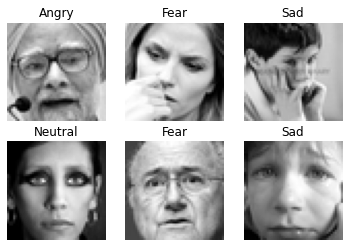

In [ ]:
for i in range(1, 7):
    plt.subplot(2, 3, i)
    plt.title(emotions[y_trn[i]])
    plt.imshow(X_trn[i, :, :, 0], cmap=plt.get_cmap('gray'))
    plt.axis('off')

#Creating a Convolutional Neural Network

In [ ]:
def conv_net(input_shape=(128, 128, 3), n_classes=6):
    """ 
    Implementation of a simple CNN architecture

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """
    activation = 'relu'
    dropout = 0.2
    n_filters = 20
    L1 = 0.0001
    
    model = Sequential()
    model.add(layers.Conv2D(n_filters, (3, 3), input_shape=input_shape))
    model.add(layers.BatchNormalization(axis=3))
    model.add(layers.Activation(activation))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    
    model.add(layers.Conv2D(n_filters*2, (3, 3), kernel_regularizer=keras.regularizers.l1(L1)))
    model.add(layers.BatchNormalization(axis=3))
    model.add(layers.Activation(activation))
    model.add(layers.Conv2D(n_filters*2, (3, 3), kernel_regularizer=keras.regularizers.l1(L1)))
    model.add(layers.BatchNormalization(axis=3))
    model.add(layers.Activation(activation))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    
    model.add(layers.Conv2D(n_filters*4, (3, 3), kernel_regularizer=keras.regularizers.l1(L1)))
    model.add(layers.BatchNormalization(axis=3))
    model.add(layers.Activation(activation))
    model.add(layers.Conv2D(n_filters*4, (3, 3), kernel_regularizer=keras.regularizers.l1(L1)))
    model.add(layers.BatchNormalization(axis=3))
    model.add(layers.Activation(activation))
    
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Flatten())
    if dropout > 0:
        model.add(layers.Dropout(dropout))
    model.add(layers.Dense(n_classes, activation='softmax'))
    return model
  
def show_training_curve(history, mode='loss'):
    epochs = range(1, len(history.history['loss'])+1)
    plt.figure(figsize=(12, 8))
    if mode == 'loss':
        plt.plot(epochs, history.history['loss'], 'b:', label='train')
        plt.plot(epochs, history.history['val_loss'], 'b', label='valid')
        plt.ylabel('Loss')
    else:
        plt.plot(epochs, history.history['accuracy'], 'b:', label='train')
        plt.plot(epochs, history.history['val_accuracy'], 'b', label='valid')
        plt.ylabel('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()
    plt.grid()
    plt.show()

In [ ]:
# Build simple model
# -----------------------------------------------------------------------------
model = conv_net(input_shape=(img_sz, img_sz, 1), n_classes=n_classes)
optimizer = keras.optimizers.Adam(lr=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

model_filename = 'fer_model.h5'
callbacks = [
    keras.callbacks.ModelCheckpoint(model_filename, save_best_only=True),
#    keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min'),
#    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=4, verbose=1,
#                                      factor=0.1, epsilon=1e-4, mode='min')
]

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_61 (Conv2D)           (None, 46, 46, 20)        200       
_________________________________________________________________
batch_normalization_61 (Batc (None, 46, 46, 20)        80        
_________________________________________________________________
activation_61 (Activation)   (None, 46, 46, 20)        0         
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 23, 23, 20)        0         
_________________________________________________________________
conv2d_62 (Conv2D)           (None, 21, 21, 40)        7240      
_________________________________________________________________
batch_normalization_62 (Batc (None, 21, 21, 40)        160       
_________________________________________________________________
activation_62 (Activation)   (None, 21, 21, 40)      

Let's train the model on the data

In [ ]:
# Fit the neural network model
history = model.fit(X_trn, to_categorical(y_trn),
                    validation_data=(X_val, to_categorical(y_val)),
                    epochs=40,
                    batch_size=128,
                    callbacks=callbacks)

Epoch 1/40
225/225 [==============================] - 4s 14ms/step - loss: 2.2389 - accuracy: 0.2714 - val_loss: 2.3684 - val_accuracy: 0.1658
Epoch 2/40
225/225 [==============================] - 3s 13ms/step - loss: 2.0053 - accuracy: 0.3740 - val_loss: 2.2050 - val_accuracy: 0.3057
Epoch 3/40
225/225 [==============================] - 3s 13ms/step - loss: 1.8990 - accuracy: 0.4205 - val_loss: 1.8983 - val_accuracy: 0.4241
Epoch 4/40
225/225 [==============================] - 3s 13ms/step - loss: 1.8402 - accuracy: 0.4444 - val_loss: 1.9542 - val_accuracy: 0.3898
Epoch 5/40
225/225 [==============================] - 3s 13ms/step - loss: 1.7800 - accuracy: 0.4709 - val_loss: 1.7537 - val_accuracy: 0.4767
Epoch 6/40
225/225 [==============================] - 3s 13ms/step - loss: 1.7340 - accuracy: 0.4841 - val_loss: 1.7361 - val_accuracy: 0.4762
Epoch 7/40
225/225 [==============================] - 3s 13ms/step - loss: 1.7063 - accuracy: 0.4911 - val_loss: 1.7479 - val_accuracy: 0.4606

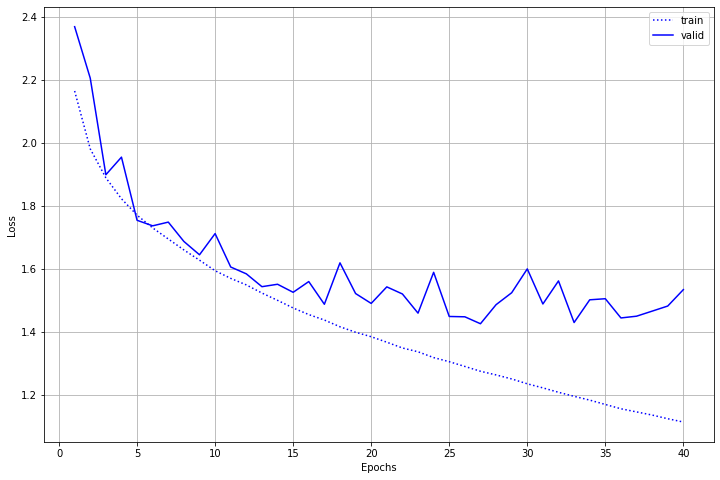

In [ ]:
show_training_curve(history, mode='loss')


Let's have a look at the *Confution Matrix* and the *Classification Report*

In [ ]:
y_pred = model.predict(X_tst)
y_pred = np.argmax(y_pred, axis=1)

acc = accuracy_score(y_tst, y_pred)

print('Accuracy: %.2f' % (acc*100))
print('\nConfusion Matrix')
print(confusion_matrix(y_tst, y_pred))

print('\nClassification Report')
print(classification_report(y_tst, y_pred, target_names=emotions.values()))


Accuracy: 53.55

Confusion Matrix
[[232   0  23  68  33   4 107]
 [ 30   4   3   6   4   0   9]
 [ 64   0  92  67  59  39 175]
 [ 34   0  11 740  15  10  85]
 [104   0  40 110 162   5 232]
 [ 19   0  21  40   6 258  71]
 [ 41   0  20  82  28   2 434]]

Classification Report
              precision    recall  f1-score   support

       Angry       0.44      0.50      0.47       467
     Disgust       1.00      0.07      0.13        56
        Fear       0.44      0.19      0.26       496
       Happy       0.66      0.83      0.74       895
         Sad       0.53      0.25      0.34       653
    Surprise       0.81      0.62      0.70       415
     Neutral       0.39      0.71      0.50       607

    accuracy                           0.54      3589
   macro avg       0.61      0.45      0.45      3589
weighted avg       0.56      0.54      0.51      3589



#Test with new images

Lets test the model on an image

In [ ]:
import cv2
from google.colab import files
from google.colab.patches import cv2_imshow

In [ ]:
uploaded = files.upload()

Saving raamin-ka-06-k8DZFJ3w-unsplash_downscaled.jpg to raamin-ka-06-k8DZFJ3w-unsplash_downscaled.jpg


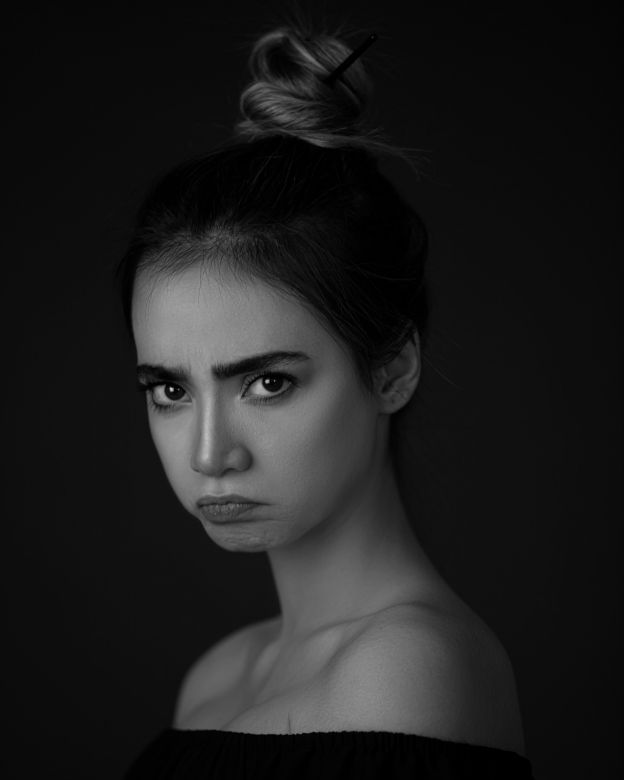

(780, 624)

In [ ]:
name = list(uploaded.keys())
img_orig = cv2.imread(name[0], cv2.IMREAD_GRAYSCALE)
cv2_imshow(img_orig)
img_orig.shape

In [ ]:
img = cv2.resize(img_orig, (img_sz, img_sz))
img.shape

(48, 48)

In [ ]:
img = img.reshape((1,img_sz, img_sz, 1)).astype(np.float32) / 255
img.shape

(1, 48, 48, 1)

In [ ]:
result = model.predict(img)
for i, prob in enumerate(result[0]):
    print('%12s: %5.1f%%' % (emotions[i], prob*100))

       Angry:  36.3%
     Disgust:   2.1%
        Fear:   5.1%
       Happy:   0.2%
         Sad:   5.4%
    Surprise:   0.5%
     Neutral:  50.3%


(-0.5, 47.5, 47.5, -0.5)

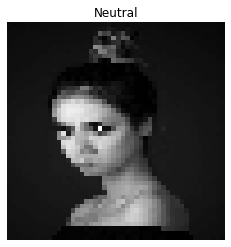

In [ ]:
plt.subplot(1, 1, 1)
plt.title(emotions[np.argmax(result[0])])
plt.imshow(img[0, :, :, 0], cmap=plt.get_cmap('gray'))
plt.axis('off')

In [ ]:
#img = img_orig[112:442, 338:668] # happy old man
img = img_orig[276:566, 122:412]  # angry young lady
print(img.shape)
img = cv2.resize(img, (img_sz, img_sz))
img = img.reshape((1,img_sz, img_sz, 1)).astype(np.float32) / 255

(290, 290)


In [ ]:
result = model.predict(img)
for i, prob in enumerate(result[0]):
    print('%12s: %5.1f%%' % (emotions[i], prob*100))

       Angry:  28.1%
     Disgust:   0.1%
        Fear:   1.0%
       Happy:   0.0%
         Sad:  10.5%
    Surprise:   0.0%
     Neutral:  60.3%


(-0.5, 47.5, 47.5, -0.5)

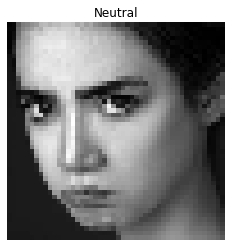

In [ ]:
plt.subplot(1, 1, 1)
plt.title(emotions[np.argmax(result[0])])
plt.imshow(img[0, :, :, 0], cmap=plt.get_cmap('gray'))
plt.axis('off')